In [1]:
import tensorflow as tf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('./rtaUtils')

from rtaUtils import paths, experiment, data_loading

import wandb, os
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
print(visible_devices)
for device in visible_devices:
    assert device.device_type != 'GPU'
    
### Features ##################################################################
numeric_feat = [
    'latitude', 'longitude', 'altitude', 'departureDelay', 'vspeed', 'speed', 
    'day_of_week', 'track', 'wind_dir_degrees', 'wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'clouds', 'hav_distance'
]
categoric_feat = [
    'time_of_day', 'operator', 'aerodromeOfDeparture', 'sky_status'
]
objective = ['RTA']

ts_features = [
    'latitude', 'longitude', 'altitude', 'vspeed', 'speed', 'track', 'hav_distance'
]
nts_features = [
    'departureDelay', 'day_of_week', 'wind_dir_degrees','wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'time_of_day', 'operator', 
    'aerodromeOfDeparture', 'sky_status', 'clouds'
]

feat_dict = dict(
    numeric=numeric_feat,
    categoric=categoric_feat,
    objective=objective,
    ts=ts_features,
    nts=nts_features
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
### Experiment setup ##########################################################
n_units      = 50
lookback     = 32
sampling     = 60

epochs       = 30

act_function = 'tanh'
batch_size   = 128
from_parquet = False

model_config = dict(
    n_units=n_units,
    act_function=act_function,
    batch_size=batch_size,
)

### Model configuration #######################################################
model_type   = 'LSTM'
months       = '*' # 20220[12]
airport      = '*'
glob_text    = f'{months}-{airport}'

In [ ]:
dt = datetime.datetime.now().strftime('%m%d_%H%M')

wandb_config = {
    'batch_size' : batch_size,
    'lookback' : lookback,
    'n_units' : n_units,
    'sampling' : sampling,
    'model_type' : model_type
}
wandb.init(project='RTAs', config=wandb_config,
           name=f'{model_type}_s{sampling}_lb{lookback}_u{n_units}_{dt}'           
           # resume='must', id=''
          ) 
wandCallback = WandbCallback(save_model=False)

## Entrenamiento

In [4]:
experimento = experiment.ExperimentVanilla(
    lookback=lookback,
    sampling=sampling,
    model_config=model_config,
    months=months, 
    airport=airport,
    features=feat_dict
)
experimento.init_model()
# experimento.load_model()
experimento.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,051
Trainable params: 14,051
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = experimento.train(epochs=epochs, from_parquet=from_parquet, add_callbacks = [wandCallback]) 
# add_callbacks = [wandCallback]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/30
7518/7518 [==============================] - 248s 33ms/step - loss: 0.0096 - mean_squared_error: 2.6241e-04 - val_loss: 0.0088 - val_mean_squared_error: 1.6021e-04
Epoch 2/30
7518/7518 [==============================] - 391s 52ms/step - loss: 0.0080 - mean_squared_error: 1.7949e-04 - val_loss: 0.0086 - val_mean_squared_error: 1.5360e-04
Epoch 3/30
7518/7518 [==============================] - 735s 98ms/step - loss: 0.0076 - mean_squared_error: 1.7056e-04 - val_loss: 0.0078 - val_mean_squared_error: 1.3148e-04
Epoch 4/30
7518/7518 [==============================] - 721s 96ms/step - loss: 0.0074 - mean_squared_error: 1.6568e-04 - val_loss: 0.0073 - val_mean_squared_error: 1.3123e-04
Epoch 5/30
7518/7518 [==============================] - 766s 102ms/step - loss: 0.0073 - mean_squar

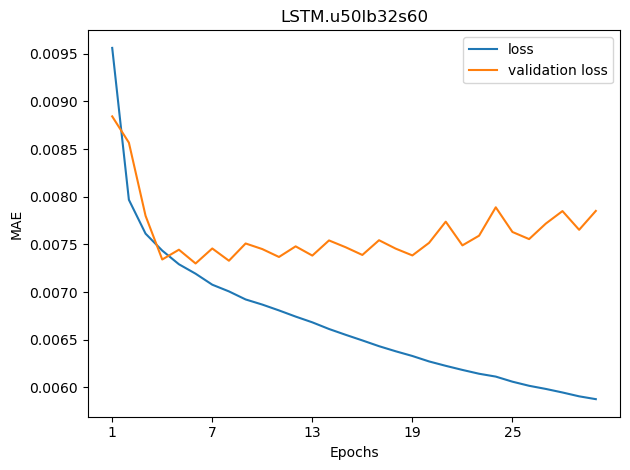

In [6]:
progress = pd.read_csv(experimento.model_path_log)
skip = 0

plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['loss'].iloc[skip:], label='loss')
plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['val_loss'].iloc[skip:], label='validation loss')
plt.title(f'{model_type}.u{n_units}lb{lookback}s{sampling}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
if progress.shape[0]>10:
    plt.xticks([str(x) for x in range(1+skip,progress.shape[0],progress.shape[0]//5)])
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación

In [5]:
experimento.load_model('best')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1337/1337 [==============================] - 23s 17ms/step
Val set           | MAE:        163.289s
                  | RMSE:       253.395s
                  | StDev:      250.051s
                  | Mean:        41.034s
                  | MAPE:         0.110
                  | Muestra:    171,112
1563/1563 [==============================] - 25s 16ms/step
Test set          | MAE:        164.308s
                  | RMSE:       262.673s
                  | StDev:      259.884s
                  | Mean:        38.177s
                  | MAPE:         0.116
                  | Muestra:    199,933


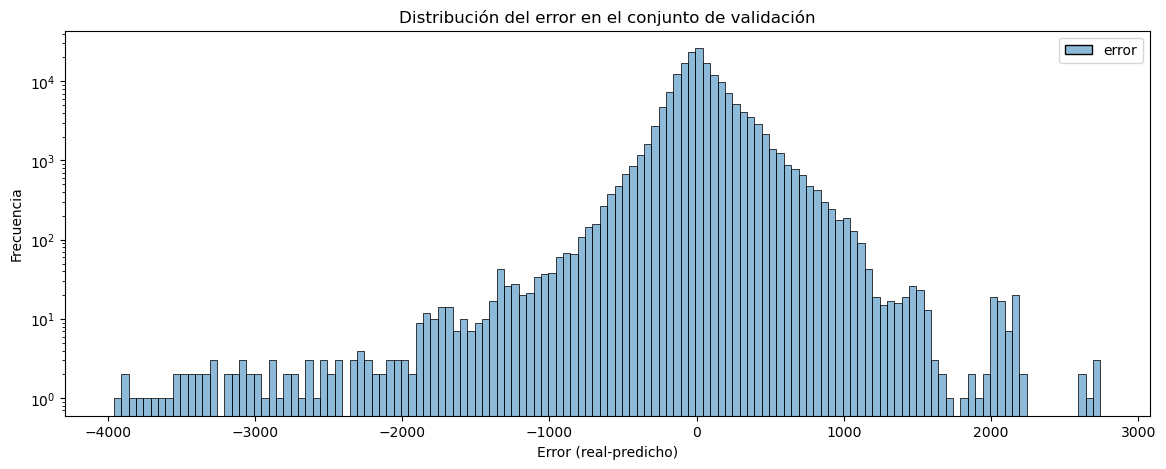

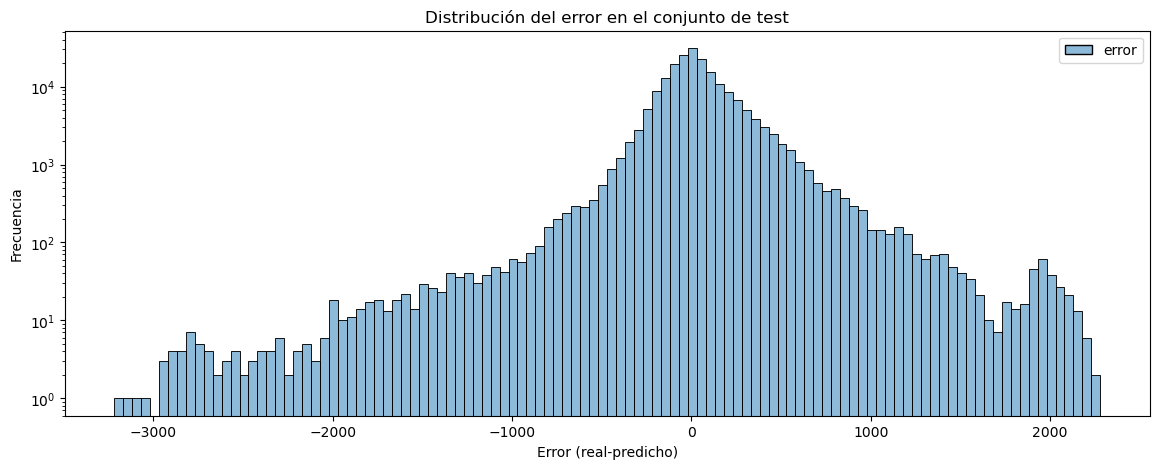

In [6]:
experimento.evaluate(from_parquet=from_parquet, print_err=True)

In [7]:
experimento.evaluate_at_times()

val: Finalizado                                                  
test: Finalizado                                                  


In [8]:
experimento.evaluate_airports()

(40/40)  Done.                                                    


## Generación de informe

In [9]:
from rtaUtils.experiment import report_columns
report_df_long = pd.DataFrame.from_dict(
    experimento.results, orient='index',
    columns=['dataset','time',*report_columns])
report_df = report_df_long.pivot_table(index=['dataset'], columns=['time'], values=report_columns)
report_df.columns = [' '.join((str(y) for y in x)) 
                     for x in report_df.columns.to_flat_index()]
report_df = report_df.reset_index()
# report_df[[x for x in report_df.columns if report_columns[0] in x]]

In [10]:
report_df

,dataset,MAE 0,MAE 15,MAE 30,MAE 60,MAE 90,MAE 120,MAE all,MAPE 0,MAPE 15,...,Sample 90,Sample 120,Sample all,StDev 0,StDev 15,StDev 30,StDev 60,StDev 90,StDev 120,StDev all
0,EBBR,273.076802,108.139290,166.309207,215.877007,393.364586,NaN,194.076011,0.050775,0.114122,...,29.0,NaN,7140.0,353.724974,165.060571,263.557365,316.369012,388.700631,NaN,316.345032
1,EDDB,279.365078,155.351964,171.811586,195.546843,239.393423,298.874360,216.609166,0.035229,0.166147,...,78.0,61.0,9852.0,384.896097,339.125856,279.272767,280.821578,337.444185,367.611201,339.554818
2,EDDF,199.439524,83.920595,132.613163,149.575968,192.111184,NaN,135.867789,0.034091,0.090621,...,71.0,NaN,8637.0,263.616734,101.120727,167.949091,237.431527,253.162320,NaN,202.788051
3,EDDH,188.660878,75.931855,153.082576,129.439589,147.458585,248.633898,132.258888,0.025940,0.080910,...,44.0,18.0,5478.0,236.196898,98.414024,249.430408,174.572454,185.894059,220.666595,186.930915
4,EDDL,274.975227,116.612657,204.024579,212.031438,257.482115,NaN,203.498067,0.044892,0.126029,...,62.0,NaN,7509.0,344.965703,264.151075,345.500219,304.719862,301.207615,NaN,322.707116
5,EDDM,192.814387,69.723100,116.973606,153.398909,203.924918,NaN,138.088790,0.031053,0.074594,...,82.0,NaN,8922.0,220.182449,87.504001,157.414548,187.771505,237.916247,NaN,179.145749
6,EDDP,255.693813,96.096909,126.409534,139.982459,186.342216,364.656827,156.813753,0.035759,0.103514,...,71.0,22.0,8309.0,401.388808,121.793351,228.700821,304.737395,336.710274,493.175343,319.157949
7,EGCC,241.421952,130.729448,174.816809,206.249464,224.545915,NaN,185.200933,0.041339,0.140750,...,30.0,NaN,2710.0,295.433758,217.144182,199.091663,249.807297,261.913473,NaN,233.495744
8,EGKK,231.716685,121.758901,188.964785,179.305757,609.774365,NaN,177.487873,0.045479,0.130397,...,10.0,NaN,4544.0,306.079771,154.839557,262.087496,224.988047,250.032887,NaN,248.317274
9,EGLL,217.429987,130.113320,241.110949,190.664987,457.145020,NaN,185.943361,0.045299,0.138952,...,9.0,NaN,3896.0,258.764092,141.276800,427.034942,236.629827,309.619227,NaN,257.703326


In [11]:
report_df.to_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                 header=True, encoding='utf8')

## Visualización

In [ ]:
import plotly.express as px

In [ ]:
report_df = pd.read_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                        header=0, encoding='utf8')

In [ ]:
vis = pd.merge(
    report_df[['MAE all','RMSE all','MAPE all', 'StDev all','Mean all','dataset']],
    pd.read_csv('./data/airports.csv', sep = ','),
    left_on='dataset', right_on='id'
)

In [ ]:
td = data_loading.load_final_data(months, 'test')[['aerodromeOfDeparture', 'fpId']].drop_duplicates()\
              .groupby('aerodromeOfDeparture').count()

vis = pd.merge(vis, td, left_on='dataset', right_on='aerodromeOfDeparture')

In [ ]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAE all', size='fpId',
#                   range_color=(50,300),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )

In [ ]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAPE all', size='fpId',
                  # range_color=(0,0.2),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )